# Crypto Market Price Movement Prediction


## Setup & Imports
Import necessary libraries and set up configuration.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from autogluon.tabular import TabularPredictor
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import os

# Set seed for reproducibility
RANDOM_STATE = 42


## Data Loading & Memory Optimisation
We’ll load train and test datasets and reduce memory usage for efficiency.


In [ ]:
# Function to reduce memory usage of a DataFrame
def reduce_mem_usage(df, verbose=True):
    """
    Reduce memory usage of a DataFrame by optimising types.
    Prints memory usage before and after, and percent saved.
    """
    import numpy as np

    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2

    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type).startswith('int'):
                # Find minimum integer type to fit the data
                if c_min >= 0:
                    if c_max < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif c_max < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif c_max < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    else:
                        df[col] = df[col].astype(np.int64)
            else:
                # Downcast floats
                df[col] = pd.to_numeric(df[col], downcast='float')
        elif col_type == object:
            num_unique_values = df[col].nunique()
            num_total_values = len(df[col])
            # If the column is text/categorical, use category type
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2

    if verbose:
        print(f"Mem. usage decreased from {start_mem:.2f} MB to {end_mem:.2f} MB "
              f"({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)")

    return df


# Load data (replace paths if running locally)
train = pd.read_parquet("/kaggle/input/drw-crypto-market-prediction/train.parquet")
test = pd.read_parquet("/kaggle/input/drw-crypto-market-prediction/test.parquet")

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

print(train.shape, test.shape)
train.head()


Mem. usage decreased from 3598.94 MB to 1805.49 MB (49.8% reduction)
Mem. usage decreased from 3678.76 MB to 1839.38 MB (50.0% reduction)
(525887, 896) (538150, 896)


,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,15.283000,8.425000,176.405,44.984001,221.389,0.121263,-0.417690,0.005399,0.125949,0.058359,...,1.925423,1.847943,0.005676,0.190791,0.369691,0.377630,0.210153,0.159183,0.530636,0.562539
2023-03-01 00:01:00,38.590000,2.336000,525.846,321.950012,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,...,1.928569,1.849468,0.005227,0.184660,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686
2023-03-01 00:02:00,0.442000,60.250000,159.227,136.369003,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,...,1.928047,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505
2023-03-01 00:03:00,4.865000,21.016001,335.742,124.962997,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,1.928621,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703
2023-03-01 00:04:00,27.158001,3.451000,98.411,44.407001,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,...,1.927084,1.848950,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452


In [3]:
test.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,...,X852,X853,X854,X855,X856,X857,X858,X859,X860,X861,X862,X863,X864,X865,X866,X867,X868,X869,X870,X871,X872,X873,X874,X875,X876,X877,X878,X879,X880,X881,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.114,12.121,10.587,10.971,21.558,-0.732818,0.512331,-0.041982,-0.598260,-0.517646,-0.720098,-0.769010,-0.780178,-0.336500,0.249788,-0.156486,-0.495663,-0.762730,-0.471363,-0.447478,-0.408999,0.535565,-0.171083,-0.227923,-0.079453,-0.041204,0.048349,0.151941,0.240157,1.353095,-0.387866,-0.276421,-0.243297,-0.186772,0.034361,0.163524,0.166223,0.135839,0.025773,0.182896,...,1.145126,1.662674,0.087326,0.602466,0.888982,0.235755,-0.074722,-1.519032e-25,0.168711,-0.033501,0.242743,-0.270279,0.000000,1.051975,0.431890,0.000000,-1.268835,-0.495721,1.056389,0.000000,0.932371,0.243075,0.237836,1.608907,3.985860,0.306682,0.343981,0.609400,0.505601,0.433290,1.014336,1.367567,1.584126,1.584126,1.584126,1.584125,1.567979,1.426368,2.192682,0.0
2,2.426,2.962,136.241,12.304,148.545,-0.337995,-0.412176,-0.259468,-0.334809,-0.247443,-0.243987,-0.214849,-0.224255,-0.539625,-0.315144,-0.202614,-0.293257,-0.508739,-0.333933,-0.336385,-0.357372,-0.348564,0.065579,0.139376,-0.047501,-0.227728,-0.145745,-0.236345,-0.519209,1.102136,0.128703,0.179227,0.128473,0.023283,0.033936,-0.123918,-0.278002,-0.225812,-0.240100,-0.184761,...,0.831423,0.638845,1.111155,1.187569,0.174188,0.353079,-0.252909,1.282684e-01,-0.502716,0.373259,0.955962,-0.356306,-0.808896,0.381690,0.718047,-1.724071,-1.204197,-0.750686,0.547839,-0.255352,0.923401,0.149122,0.210784,3.143691,3.913445,0.231629,0.312275,0.685310,0.661501,0.725448,1.748939,1.848177,0.000131,0.000323,0.001746,0.007319,0.050925,0.142206,0.739759,0.0
3,1.085,2.343,23.390,57.171,80.561,0.111249,0.458221,0.466916,0.574081,0.324722,0.291298,0.295451,0.324332,-0.007327,0.351338,0.358218,0.329307,0.290870,0.012313,-0.008258,0.057786,0.332306,0.167834,0.197985,0.102250,0.060063,-0.139541,-0.224249,-0.246030,0.215433,0.150163,0.046509,0.044225,0.003683,-0.213760,-0.408667,-0.295609,0.029641,0.029593,0.021453,...,0.983454,1.521962,0.665538,0.589635,-0.265510,-0.340681,-0.002949,1.361271e-01,0.273964,0.286688,-0.488119,0.268433,0.000000,0.230857,0.192657,0.000000,-0.618164,0.000000,0.000000,0.000000,0.000000,0.252338,0.203609,1.702517,3.665623,0.229644,0.278697,0.592664,0.629683,0.743693,1.704680,1.772028,0.000550,0.003597,0.009265,0.019948,0.072535,0.169672,0.807862,0.0
4,14.793,1.117,116.518,13.082,129.600,-0.149399,-0.640638,-0.873778,-1.026144,-0.508816,-0.318499,-0.270990,-0.269990,-0.206264,-0.491395,-0.791609,-0.849243,-0.737791,-0.213973,-0.258329,-0.334767,-0.501566,-0.143377,-0.101949,-0.043811,-0.021846,0.030501,-0.010734,-0.143917,1.897930,0.166798,0.151133,0.156303,0.179812,0.145286,0.095092,-0.050541,-0.233126,-0.197698,-0.239907,...,1.793580,1.609115,0.140885,0.945045,1.247777,-0.175964,-0.279785,-4.272722e-43,-0.312154,0.121647,0.145365,-0.364048,-0.394350,0.338114,0.409994,-0.882540,-2.191214,-0.716939,-0.961222,0.954427,1.652734,0.164450,0.234660,2.349036,3.508278,0.164611,0.178355,0.380719,0.406191,0.451041,0.930946,1.037839,1.382037,1.382037,1.382037,1.382037,1.381752,1.363445,2.465509,0.0
5,0.033,14.178,43.800,49.836,93.636,-0.694662,0.611254,0.067671,-0.531632,-0.581450,-0.670998,-0.658519,-0.641033,-0.709044,0.522476,0.176614,-0.358000,-0.913063,-0.542747,-0.549789,-0.535438,-0.039000,0.497418,0.220629,0.023939,-0.064359,-0.030559,-0.063269,-0.141931,2.018999,-0.201351,-0.259154,-0.308402,-0.341364,-0.106369,0.003638,0.151764,-0.216639,-0.262946,-0.172207,...,0.673395,1.162847,0.587153,0.528421,0.286078,-0.345662,-0.122057,-9.694950e-01,0.065162,0.172275,-0.383390,0.184046,1.440230,0.815732,0.357557,-0.595227,0.096416,-0.209686,-0.476400,-1.026

In [3]:
# Reset index for train
train = train.reset_index().rename(columns={'index': 'timestamp'})

# Reset index for test (if you want consistency)
test = test.reset_index().rename(columns={'index': 'ID'})


In [39]:
# Convert timestamp to datetime
train['weekday'] = train['timestamp'].dt.day_name()
train['month'] = train['timestamp'].dt.month_name()

In [4]:
# # Load a sample from the parquet file
# df_sample = train.head(500)

# # Export sample as CSV
# df_sample.to_csv("train_sample.csv", index=False)

## Exploratory Data Analysis (EDA)
Look at distributions, missing values, feature correlation, and label.


In [14]:
# Overview
print(train.info())
print(train.describe().T)

# Check missing values
missing = train.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525887 entries, 2023-03-01 00:00:00 to 2024-02-29 23:59:00
Columns: 896 entries, bid_qty to label
dtypes: float64(896)
memory usage: 3.5 GB
None


C:\Users\sirap\AppData\Roaming\Python\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\sirap\AppData\Roaming\Python\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\sirap\AppData\Roaming\Python\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\sirap\AppData\Local\Programs\Python\Python311\Li

             count        mean  ...         75%           max
bid_qty   525887.0    9.968003  ...   13.085000   1114.932000
ask_qty   525887.0   10.174169  ...   13.330000   1352.965000
buy_qty   525887.0  131.726678  ...  127.639000  17614.400000
sell_qty  525887.0  132.673944  ...  129.110000  17686.234000
volume    525887.0  264.400622  ...  256.733500  28701.419000
...            ...         ...  ...         ...           ...
X887      525887.0    0.497872  ...    1.380184      1.584315
X888      525887.0    0.497525  ...    1.120480      1.583862
X889      525887.0    0.497372  ...    0.999344      1.557910
X890      525887.0    0.995394  ...    1.701838      2.769604
label     525887.0    0.036126  ...    0.434135     20.740270

[896 rows x 8 columns]
Series([], dtype: float64)


In [11]:
# Check for missing values and data types
print("Train Shape:", train.shape)
print("Train Missing values:", train.isnull().sum().sum())

print("Test Shape:", test.shape)
print("Test Missing values:", test.isnull().sum().sum())


Train Shape: (525887, 896)
Train Missing values: 0
Test Shape: (538150, 896)
Test Missing values: 0


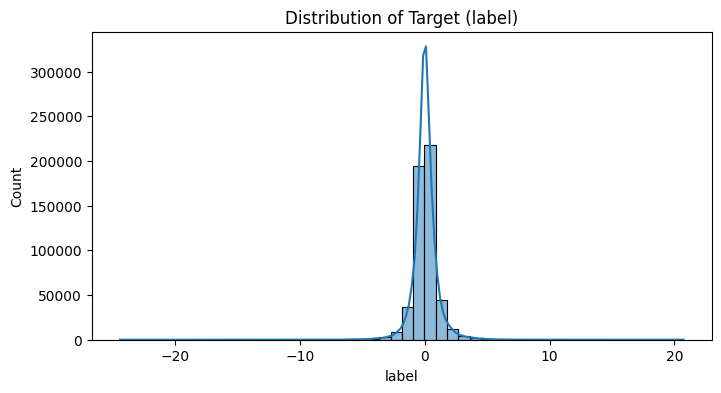

In [15]:
# Label distribution
plt.figure(figsize=(8,4))
sns.histplot(train['label'], bins=50, kde=True)
plt.title('Distribution of Target (label)')
plt.show()

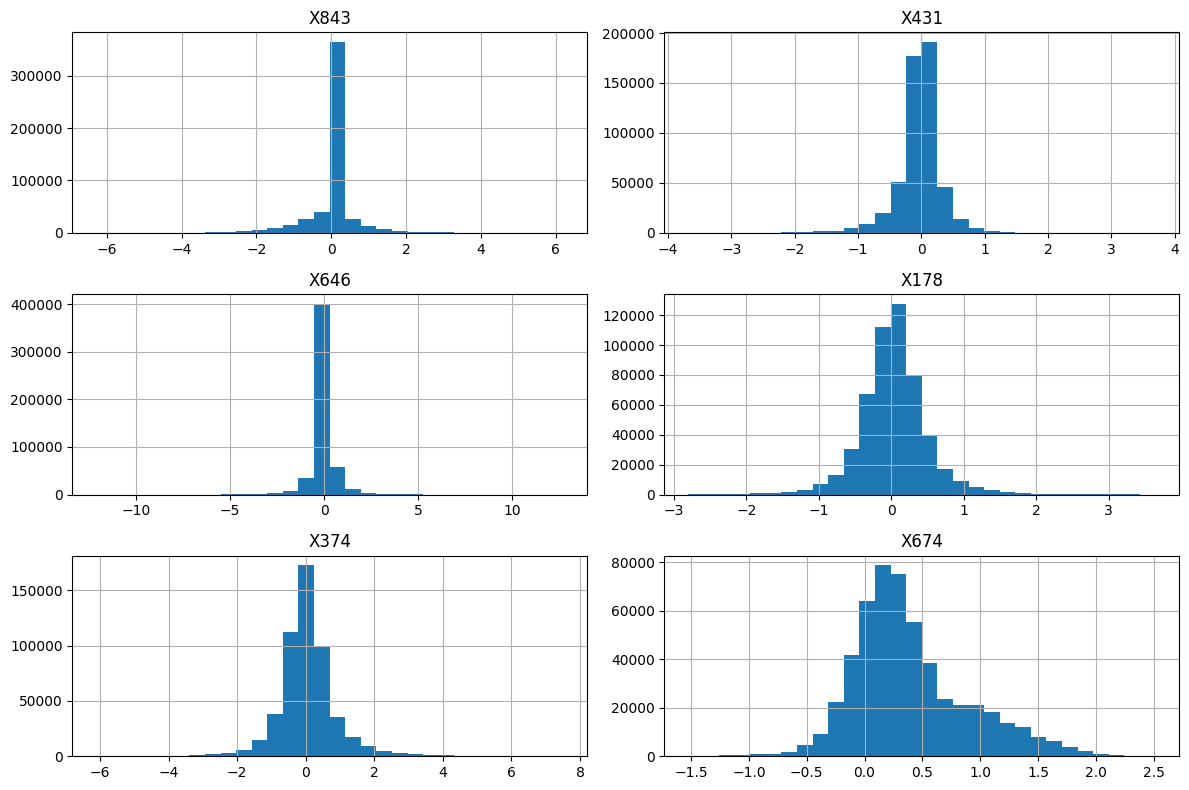

In [13]:
# Random Sample of Anonymised Features
anon_cols = [col for col in train.columns if col.startswith('X')]
sample_cols = np.random.choice(anon_cols, 6, replace=False)
train[sample_cols].hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()


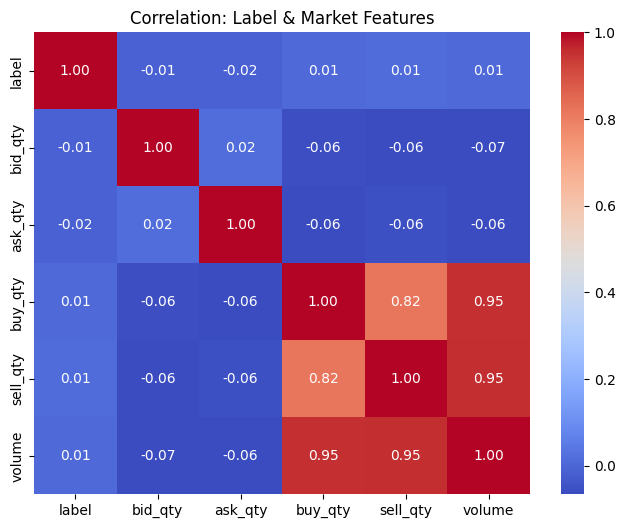

In [35]:
# Market Features Correlation
market_cols = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
corr = train[['label'] + market_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation: Label & Market Features')
plt.show()


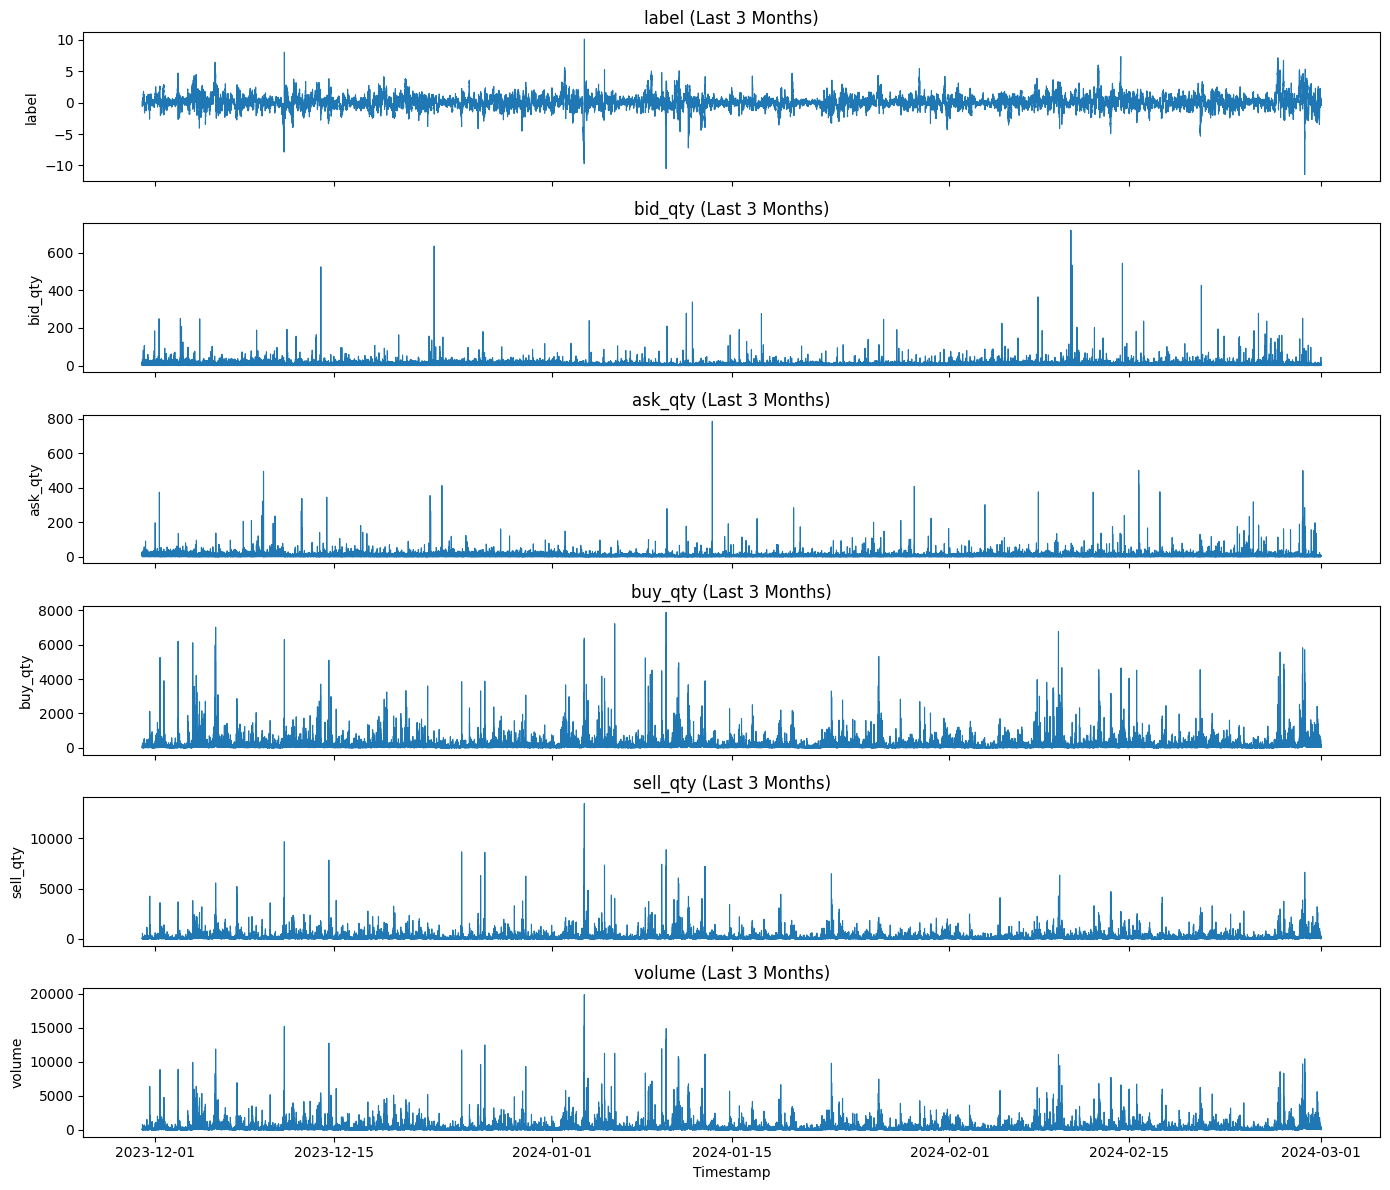

In [28]:
# Filter for the last 3 months
last_time = train['timestamp'].max()
three_months_ago = last_time - pd.DateOffset(months=3)
recent_train = train[train['timestamp'] >= three_months_ago]

cols_to_plot = ['label', 'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
fig, axes = plt.subplots(len(cols_to_plot), 1, figsize=(14, 12), sharex=True)

for i, col in enumerate(cols_to_plot):
    axes[i].plot(recent_train['timestamp'], recent_train[col], lw=0.8)
    axes[i].set_title(f"{col} (Last 3 Months)")
    axes[i].set_ylabel(col)

axes[-1].set_xlabel("Timestamp")
plt.tight_layout()
plt.show()


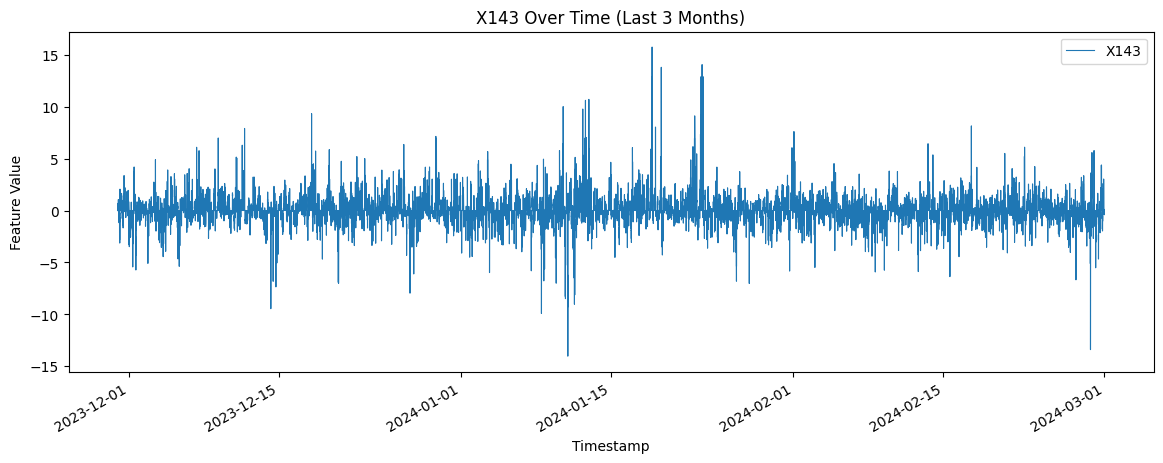

In [29]:
# Anonymised Feature Over Time
anon_cols = [c for c in train.columns if c.startswith('X')]
sample_anon = np.random.choice(anon_cols, 1, replace=False)

recent_train.set_index('timestamp')[sample_anon].plot(figsize=(14, 5), lw=0.8)
plt.title(f"{sample_anon[0]} Over Time (Last 3 Months)")
plt.xlabel("Timestamp")
plt.ylabel("Feature Value")
plt.show()


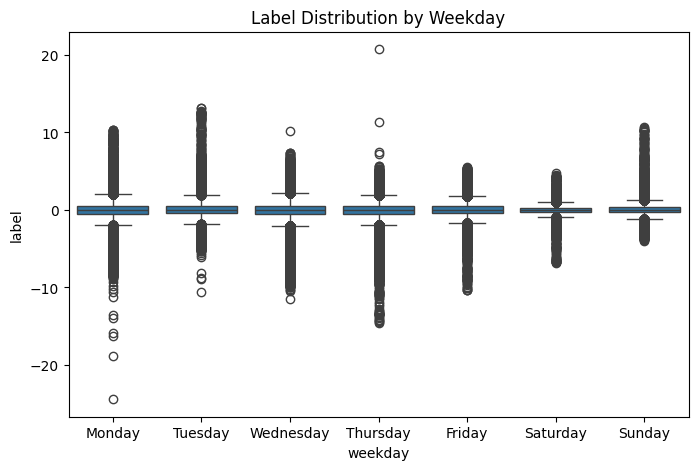

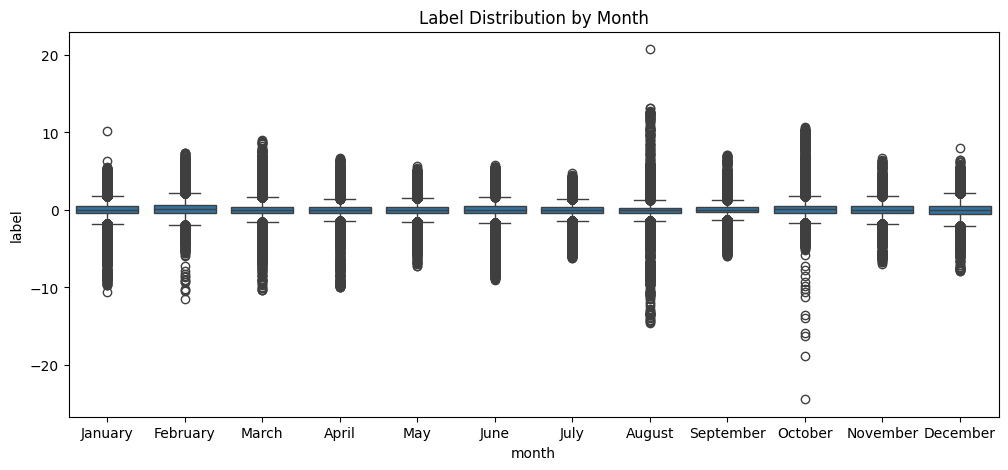

In [34]:
plt.figure(figsize=(8,5))
sns.boxplot(data=train, x='weekday', y='label', order=weekday_order)
plt.title("Label Distribution by Weekday")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(data=train, x='month', y='label', order=month_order)
plt.title("Label Distribution by Month")
plt.show()


In [20]:
# Skewness of Market Features
print(train[market_cols + ['label']].skew())


bid_qty     16.583564
ask_qty     17.915200
buy_qty     13.356080
sell_qty    12.952494
volume      11.901218
label       -0.113488
dtype: float64


### Summary 

- Both the market features and many of the anonymised features (X_ columns) show a roughly bell-shaped curve, which is good for modelling.
- Outliers still exist, especially in trading volume and quantities, but not to an extreme degree.
- Market Features and Anonymised Features are on different scales. This means feature scaling (like StandardScaler or MinMaxScaler) could be required.
- The target variable (label) has very low correlation with all market features, meaning no strong predictors for the label among the market features—so most predictive power will probably come from the anonymised features.
- buy_qty, sell_qty, and volume are highly correlated with each other (> 0.9), which makes sense as they're all related to trading activity.
- Label distribution by weekday and month appears stable, with no obvious seasonality.


> That said, high correlation among some features (multicollinearity) could affect some models. So, don't expect basic models on market features alone to perform well. The real signal is likely buried in the anonymised features. Adding day of week, month as categorical features is optional. Though, they are unlikely to add much predictive value, including them won’t hurt.

## Feature Engineering

> **Plan**
> - Generate lag and rolling features in both train and test set.
> - **Do not** consider time features (weekday/month) as timestamp is not available in test set.
> - Apply scaler and use the scaler already fitted on train, on test.
> - lag/rolling near the start of the train and test set (these rows will have NaNs, so use the nearest value to avoid dropping).

Lag and rolling features are used because they allow the model to capture short- and medium-term trends and momentum, which can help the model identify patterns such as sudden surges, drops, or ongoing trends. Time-based features (weekday, month) are intentionally excluded. Since the test set does not provide timestamps. Standardisation with a fitted scaler ensures that all features have a similar scale. By fitting the scaler only on the training data and applying the same transformation to the test data, we prevent data leakage and make sure the model generalises correctly. Lastly, handling NaNs for lag and rolling features (at the beginning of each set) by forward or backward filling ensures no data is lost.

In [6]:
# market_cols = ['bid_qty', 'ask_qty', 'volume']

# # --- Generate lag features ---
# for col in market_cols:
#     train[f'{col}_lag10'] = train[col].shift(10)
#     train[f'{col}_lag60'] = train[col].shift(60)
#     test[f'{col}_lag10'] = test[col].shift(10)
#     test[f'{col}_lag60'] = test[col].shift(60)

# # --- Generate rolling mean features ---
# for col in market_cols:
#     train[f'{col}_rollmean10'] = train[col].rolling(window=10).mean()
#     train[f'{col}_rollmean60'] = train[col].rolling(window=60).mean()
#     test[f'{col}_rollmean10'] = test[col].rolling(window=10).mean()
#     test[f'{col}_rollmean60'] = test[col].rolling(window=60).mean()

# --- Fill missing values (forward then backward fill) ---
train = train.fillna(method='ffill').fillna(method='bfill')
test = test.fillna(method='ffill').fillna(method='bfill')

# --- Scale only numerical columns ---
# Replace inf/-inf with NaN
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Now fill those new NaNs (again)
train = train.fillna(method='ffill').fillna(method='bfill')
test = test.fillna(method='ffill').fillna(method='bfill')

# --- Add engineered features ---
# Ref: https://www.kaggle.com/code/taylorsamarel/low-signal-to-noise/notebook
for df in [train, test]:
    df['volume_weighted_sell'] = df['sell_qty'] * df['volume']
    df['buy_sell_ratio'] = df['buy_qty'] / (df['sell_qty'] + 1e-8)
    df['selling_pressure'] = df['sell_qty'] / (df['volume'] + 1e-8)
    df['effective_spread_proxy'] = np.abs(df['buy_qty'] - df['sell_qty']) / (df['volume'] + 1e-8)
    df['log_volume'] = np.log1p(df['volume'])
    df['bid_ask_imbalance'] = (df['bid_qty'] - df['ask_qty']) / (df['bid_qty'] + df['ask_qty'] + 1e-8)
    df['order_flow_imbalance'] = (df['buy_qty'] - df['sell_qty']) / (df['buy_qty'] + df['sell_qty'] + 1e-8)
    df['liquidity_ratio'] = (df['bid_qty'] + df['ask_qty']) / (df['volume'] + 1e-8)
    
# More:
for df in [train, test]:
    df['bid_ask_interaction'] = df['bid_qty'] * df['ask_qty']
    df['bid_buy_interaction'] = df['bid_qty'] * df['buy_qty']
    df['bid_sell_interaction'] = df['bid_qty'] * df['sell_qty']
    df['ask_buy_interaction'] = df['ask_qty'] * df['buy_qty']
    df['ask_sell_interaction'] = df['ask_qty'] * df['sell_qty']
    df['buy_sell_interaction'] = df['buy_qty'] * df['sell_qty']
    df['spread_indicator'] = (df['ask_qty'] - df['bid_qty']) / (df['ask_qty'] + df['bid_qty'] + 1e-8)
    df['volume_weighted_buy'] = df['buy_qty'] * df['volume']
    df['volume_weighted_bid'] = df['bid_qty'] * df['volume']
    df['volume_weighted_ask'] = df['ask_qty'] * df['volume']
    df['bid_ask_ratio'] = df['bid_qty'] / (df['ask_qty'] + 1e-8)
    df['buying_pressure'] = df['buy_qty'] / (df['volume'] + 1e-8)
    df['total_liquidity'] = df['bid_qty'] + df['ask_qty']
    df['liquidity_imbalance'] = (df['bid_qty'] - df['ask_qty']) / (df['total_liquidity'] + 1e-8)
    df['relative_spread'] = (df['ask_qty'] - df['bid_qty']) / (df['volume'] + 1e-8)
    df['trade_intensity'] = (df['buy_qty'] + df['sell_qty']) / (df['volume'] + 1e-8)
    df['avg_trade_size'] = df['volume'] / (df['buy_qty'] + df['sell_qty'] + 1e-8)
    df['net_trade_flow'] = (df['buy_qty'] - df['sell_qty']) / (df['buy_qty'] + df['sell_qty'] + 1e-8)
    df['depth_ratio'] = df['total_liquidity'] / (df['volume'] + 1e-8)
    df['volume_participation'] = (df['buy_qty'] + df['sell_qty']) / (df['total_liquidity'] + 1e-8)
    df['market_activity'] = df['volume'] * df['total_liquidity']
    df['realized_volatility_proxy'] = np.abs(df['order_flow_imbalance']) * df['volume']
    df['normalized_buy_volume'] = df['buy_qty'] / (df['bid_qty'] + 1e-8)
    df['normalized_sell_volume'] = df['sell_qty'] / (df['ask_qty'] + 1e-8)
    df['liquidity_adjusted_imbalance'] = df['order_flow_imbalance'] * df['depth_ratio']
    df['pressure_spread_interaction'] = df['buying_pressure'] * df['spread_indicator']


# feature_cols = [c for c in train.columns if (
#     c not in ['timestamp', 'weekday', 'month', 'label'] and 
#     pd.api.types.is_numeric_dtype(train[c])
# )]

# # Scale the features
# scaler = StandardScaler()
# train[feature_cols] = scaler.fit_transform(train[feature_cols])
# test[feature_cols] = scaler.transform(test[feature_cols])


C:\Users\sirap\AppData\Local\Temp\ipykernel_19016\4276926531.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = train.fillna(method='ffill').fillna(method='bfill')
C:\Users\sirap\AppData\Local\Temp\ipykernel_19016\4276926531.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = test.fillna(method='ffill').fillna(method='bfill')
C:\Users\sirap\AppData\Local\Temp\ipykernel_19016\4276926531.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = train.fillna(method='ffill').fillna(method='bfill')
C:\Users\sirap\AppData\Local\Temp\ipykernel_19016\4276926531.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [6]:
# Print final shapes
print(train.shape, test.shape)

(525887, 897) (538150, 897)


### Feature Selection

It seems that, with all the available features, it causes a memory issue during model trainning process using AutoGluon. Thus, feature selection is applied using XGBoost.

In [44]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Sort by timestamp
train_data = train.sort_values('timestamp').reset_index(drop=True)

X = train_data.drop(columns=['label', 'timestamp'])
y = train_data['label']

# Use TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)

feature_importances = []

for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    feature_importances.append(model.feature_importances_)

# Average feature importances across all folds
avg_importance = np.mean(feature_importances, axis=0)

# Attach feature names
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, avg_importance))


In [45]:
# To get the top features
top_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print(top_features)

[('X785', 0.01591182), ('X624', 0.008732522), ('X296', 0.007060611), ('X507', 0.0070087053), ('X198', 0.006874564), ('X782', 0.0067940718), ('X855', 0.0067924606), ('X753', 0.0066572027), ('X444', 0.006620329), ('X543', 0.006485876), ('X425', 0.00619291), ('X300', 0.0056434376), ('X752', 0.005632046), ('X530', 0.0056042606), ('X862', 0.0055814967), ('X219', 0.0054534976), ('X537', 0.0053060474), ('X179', 0.0052109784), ('X586', 0.005151068), ('X784', 0.0051100245), ('X39', 0.0049521765), ('X344', 0.0049510146), ('X345', 0.004901484), ('X466', 0.0048584216), ('X757', 0.0047641834), ('X890', 0.00474694), ('X331', 0.0046682074), ('X886', 0.0046295123), ('X731', 0.0046050265), ('X677', 0.004332161), ('X465', 0.0042130467), ('X37', 0.0041671423), ('X98', 0.0041653286), ('X854', 0.0041314526), ('X295', 0.0041297665), ('X865', 0.00407978), ('X582', 0.0040284996), ('X534', 0.0040040957), ('X379', 0.0039287186), ('X585', 0.0039034015), ('X385', 0.0038178863), ('X540', 0.0037463426), ('X696', 0.

In [24]:
# A list of top 20 features
# top_features = [feature for feature, importance in top_features[:20]]
top_features = ['X785',
 'X296',
 'X444',
 'X534',
 'X198',
 'X782',
 'X757',
 'X752',
 'X344',
 'X886',
 'X753',
 'X862',
 'X543',
 'X425',
 'X890',
 'X219',
 'X331',
 'X345',
 'X39',
 'X179']

In [ ]:
# # Create a list of engineered features 
# engineered_cols = []
# for col in market_cols:
#     engineered_cols += [f'{col}_lag10', f'{col}_lag60', f'{col}_rollmean10', f'{col}_rollmean60']

# # Prepare data for main model
# train_data_reduced = train[top_features + ['label'] + engineered_cols]
# test_data_reduced = test[top_features + engineered_cols + ['label']]


In [ ]:
# market_cols = ['bid_qty', 'ask_qty', 'volume', 'buy_qty', 'sell_qty']

# # Prepare data for main model
# train_data_reduced = train[top_features + market_cols + ['label']]
# test_data_reduced = test[top_features + market_cols + ['label']]

In [ ]:
# import shap

# # Calculate SHAP values
# explainer = shap.Explainer(model, X)
# shap_values = explainer(X)

# # Visualise summary plot
# shap.summary_plot(shap_values, X)
# plt.show()

In [22]:
# Select features based on SHAP values using XGBoost trained on all features with OPTUNA for hyperparameter tuning
# Ref: https://www.kaggle.com/code/sadettinamilverdil/yat-r-m-tavsiyesi-de-ildir
# FEATURES = [
#     "X863", "X856", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
#     "X415", "X345", "X855", "X174", "X302", "X178", "X168", "X612", "X888", "X421", "X333",
#     "buy_qty", "sell_qty", "volume"
# ]

FEATURES = [
    # Select features based on SHAP values using XGBoost trained on all features with OPTUNA for hyperparameter tuning
    # Ref: https://www.kaggle.com/code/sadettinamilverdil/yat-r-m-tavsiyesi-de-ildir
    "X863", "X856", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X855", "X174", "X302", "X178", "X168", "X612", "X888", "X421", "X333",
    "buy_qty", "sell_qty", "volume", "bid_qty", "ask_qty",
    # Engineered features below
    "volume_weighted_sell", "buy_sell_ratio", "selling_pressure", 
    "effective_spread_proxy", "log_volume", "bid_ask_imbalance",
    "order_flow_imbalance", "liquidity_ratio",
    # More engineered features
    "bid_ask_interaction", "bid_buy_interaction", "bid_sell_interaction",
    "ask_buy_interaction", "ask_sell_interaction", "buy_sell_interaction",
    "spread_indicator", "volume_weighted_buy", "volume_weighted_bid",
    "volume_weighted_ask", "bid_ask_ratio", "buying_pressure",
    "total_liquidity", "liquidity_imbalance", "relative_spread",
    "trade_intensity", "avg_trade_size", "net_trade_flow",
    "depth_ratio", "volume_participation", "market_activity",
    "realized_volatility_proxy", "normalized_buy_volume", "normalized_sell_volume",
    "liquidity_adjusted_imbalance", "pressure_spread_interaction"
]


train_data_reduced = train[FEATURES + ['label']]
test_data_reduced = test[FEATURES + ['label']]

In [23]:
print(train_data_reduced.shape, test_data_reduced.shape)

(525887, 60) (538150, 60)


### Experiments

- Take the earliest 90% as the “pool”

- Use the latest 25%, 50%, 75%, and 100% of that 90% pool for training (so, most recent first)

- Always test on the latest 10%

**TimeSeriesSplit** won't work as expected due to the nature of this competition.

In [ ]:
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from scipy.stats import pearsonr

# Split latest 10% for local test set
n = len(train_data_reduced)
n_test = int(n * 0.10)
n_train = n - n_test

train_pool = train_data_reduced.iloc[:n_train]
test_part = train_data_reduced.iloc[n_train:].sample(frac=1, random_state=42).reset_index(drop=True)  # shuffled test

X_test = test_part.drop(columns=['label'])
y_test = test_part['label']

percentages = [0.25, 0.5, 0.75, 1.0]
results = []

for pct in percentages:
    n_train_pct = int(len(train_pool) * pct)
    train_slice = train_pool.iloc[-n_train_pct:]  # Take most recent data for training
    X_train = train_slice.drop(columns=['label'])
    y_train = train_slice['label']

    print(f"\nTraining on latest {int(pct*100)}% of train data ({n_train_pct} samples)...")

    # Train LightGBM
    lgb_model = lgb.LGBMRegressor(verbose=-1)
    lgb_model.fit(X_train, y_train)

    # Train XGBoost
    xgb_model = xgb.XGBRegressor(tree_method="hist", device='cpu', n_jobs=4, verbosity=0)
    xgb_model.fit(X_train, y_train)

    # Predict and ensemble
    lgb_pred = lgb_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    ensemble_pred = (lgb_pred + xgb_pred) / 2

    pearson_ensemble, _ = pearsonr(ensemble_pred, y_test)
    print(f"  Ensemble Pearson on last 10% (shuffled): {pearson_ensemble:.4f}")

    results.append({
        "train_percentage": pct,
        "train_size": n_train_pct,
        "pearson_ensemble": pearson_ensemble
    })

# Print a summary table
print("\n=== Summary ===")
for r in results:
    print(f"Latest {int(r['train_percentage']*100)}% of train data | Train size: {r['train_size']} | Ensemble Pearson: {r['pearson_ensemble']:.4f}")



Training on latest 100% of train data (473299 samples)...


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


  Ensemble Pearson on last 10% (shuffled): 0.1177

=== Summary ===
Latest 100% of train data | Train size: 473299 | Ensemble Pearson: 0.1177


- It seems that our best bet is to use 65% of the training dataset as it performed the best based on this experiment *(**Not true, more experiments needed**).
- I am not sure why when I put the training data on shuffle, it performed better. Probably because of the testing is shuffled so all of the time relations becomes irrelevant.

#### Weighted Average

- Splits off the latest 10% of train_data_reduced as a hold-out test set (shuffled).

- Uses the earlier 90% as training pool (shuffled as well).

- Trains both LightGBM and XGBoost models on the shuffled training pool.

- Blends their predictions on the hold-out test set using a range of weights (e.g. from 0 to 1 in 0.1 steps).

- Finds and reports the best weighted average for Pearson correlation.

- Outputs a summary table of weights and corresponding Pearson scores.

In [60]:
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from scipy.stats import pearsonr
import pandas as pd

# Split latest 10% as hold-out test, earlier 90% as training pool
n = len(train_data_reduced)
n_test = int(n * 0.10)
n_train = n - n_test

train_part = train_data_reduced.iloc[:n_train].sample(frac=1, random_state=42).reset_index(drop=True)  # shuffled train
test_part = train_data_reduced.iloc[n_train:].sample(frac=1, random_state=42).reset_index(drop=True)   # shuffled test

X_train = train_part.drop(columns=['label'])
y_train = train_part['label']
X_test = test_part.drop(columns=['label'])
y_test = test_part['label']

# Train LightGBM
print("Training LightGBM...")
lgb_model = lgb.LGBMRegressor(verbose=-1)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

# Train XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(tree_method="hist", device='cpu', n_jobs=4, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Weighted average experiment
weights = np.arange(0, 1.01, 0.1)
results = []
for w in weights:
    ensemble_pred = w * lgb_pred + (1 - w) * xgb_pred
    pearson_score, _ = pearsonr(ensemble_pred, y_test)
    results.append({"LGB_weight": w, "XGB_weight": 1-w, "Pearson": pearson_score})

# Create summary table
summary_df = pd.DataFrame(results)
print("\n=== Weighted Average Pearson Results ===")
print(summary_df.to_string(index=False))

# Find the best weight
best_row = summary_df.loc[summary_df['Pearson'].idxmax()]
print(f"\nBest weighted blend: LGB_weight = {best_row.LGB_weight:.2f}, XGB_weight = {best_row.XGB_weight:.2f}, Pearson = {best_row.Pearson:.4f}")


Training LightGBM...
Training XGBoost...

=== Weighted Average Pearson Results ===
 LGB_weight  XGB_weight  Pearson
        0.0         1.0 0.124708
        0.1         0.9 0.128873
        0.2         0.8 0.133291
        0.3         0.7 0.137834
        0.4         0.6 0.142257
        0.5         0.5 0.146125
        0.6         0.4 0.148763
        0.7         0.3 0.149247
        0.8         0.2 0.146565
        0.9         0.1 0.139994
        1.0         0.0 0.129544

Best weighted blend: LGB_weight = 0.70, XGB_weight = 0.30, Pearson = 0.1492


#### RandomSearchCV

- Tune LightGBM with RandomisedSearchCV to get best_lgb.
- Tune XGBoost with RandomisedSearchCV to get best_xgb.
- Use both to predict on your holdout test set.
- Blend the predictions with your best weights (e.g. 0.7/0.3).
- Report the Pearson score.

In [68]:
from sklearn.model_selection import RandomizedSearchCV, KFold
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# Data prep as before
n = len(train_data_reduced)
n_test = int(n * 0.10)
n_train = n - n_test

train_part = train_data_reduced.iloc[:n_train].sample(frac=1, random_state=42).reset_index(drop=True)
test_part = train_data_reduced.iloc[n_train:].sample(frac=1, random_state=42).reset_index(drop=True)

X_train = train_part.drop(columns=['label'])
y_train = train_part['label']
X_test = test_part.drop(columns=['label'])
y_test = test_part['label']

# LightGBM RandomisedSearchCV
lgb_param_dist = {
    'num_leaves':    [40, 60, 80, 100, 120, 140, 160],
    'max_depth':     [5, 6, 7, 8, 10, 12, 15],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'n_estimators':  [500, 800, 1000, 1200, 1500],
    'subsample':     [0.8, 0.9, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1.0],
    'reg_alpha':     [0.5, 1, 2, 5],
    'reg_lambda':    [0, 0.1, 1, 2, 5]
}
cv = KFold(n_splits=3, shuffle=True, random_state=42)
lgb_model = lgb.LGBMRegressor(verbose=-1)
lgb_search = RandomizedSearchCV(
    lgb_model, param_distributions=lgb_param_dist, n_iter=20,
    scoring='neg_root_mean_squared_error', cv=cv, verbose=2, random_state=42, n_jobs=-1
)
print("\nRunning RandomisedSearchCV for LightGBM...")
lgb_search.fit(X_train, y_train)
best_lgb = lgb_search.best_estimator_
lgb_pred = best_lgb.predict(X_test)

# XGBoost RandomisedSearchCV
xgb_param_dist = {
    'max_depth':     [5, 6, 7, 8, 10, 12, 15],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'n_estimators':  [500, 800, 1000, 1200, 1500],
    'subsample':     [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha':     [0.5, 1, 2, 5],
    'reg_lambda':    [0, 0.1, 1, 2, 5]
}
xgb_model = xgb.XGBRegressor(tree_method="hist", device='cpu', n_jobs=4, verbosity=0)
xgb_search = RandomizedSearchCV(
    xgb_model, param_distributions=xgb_param_dist, n_iter=20,
    scoring='neg_root_mean_squared_error', cv=cv, verbose=2, random_state=42, n_jobs=-1
)
print("\nRunning RandomisedSearchCV for XGBoost...")
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
xgb_pred = best_xgb.predict(X_test)

# Weighted blend (best found: LGB 0.7, XGB 0.3)
blend_pred = 0.7 * lgb_pred + 0.3 * xgb_pred
pearson_blend, _ = pearsonr(blend_pred, y_test)

print(f"\nBest weighted blend (LGB 0.7, XGB 0.3) Pearson: {pearson_blend:.4f}")

# Optionally: summary table of all 3
results = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost", "Blend(0.7/0.3)"],
    "Pearson": [
        pearsonr(lgb_pred, y_test)[0],
        pearsonr(xgb_pred, y_test)[0],
        pearson_blend
    ]
})
print("\nSummary:\n", results.to_string(index=False))



Running RandomisedSearchCV for LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Running RandomisedSearchCV for XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best weighted blend (LGB 0.7, XGB 0.3) Pearson: 0.1335

Summary:
          Model  Pearson
      LightGBM 0.120826
       XGBoost 0.137526
Blend(0.7/0.3) 0.133458


In [69]:
print("Best LightGBM parameters:")
print(lgb_search.best_params_)

print("\nBest XGBoost parameters:")
print(xgb_search.best_params_)


Best LightGBM parameters:
{'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 5, 'num_leaves': 120, 'n_estimators': 1500, 'max_depth': 15, 'learning_rate': 0.2, 'colsample_bytree': 0.5}

Best XGBoost parameters:
{'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 1200, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [9]:
from sklearn.model_selection import RandomizedSearchCV, KFold
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# Data prep as before
n = len(train_data_reduced)
n_test = int(n * 0.10)
n_train = n - n_test

train_part = train_data_reduced.iloc[:n_train].sample(frac=1, random_state=42).reset_index(drop=True)
test_part = train_data_reduced.iloc[n_train:].sample(frac=1, random_state=42).reset_index(drop=True)

X_train = train_part.drop(columns=['label'])
y_train = train_part['label']
X_test = test_part.drop(columns=['label'])
y_test = test_part['label']

In [10]:
# Train LightGBM with best parameters
print("Training LightGBM (tuned)...")
lgb_model = lgb.LGBMRegressor(
    subsample=1.0,
    reg_lambda=0,
    reg_alpha=5,
    num_leaves=120,
    n_estimators=1500,
    max_depth=15,
    learning_rate=0.2,
    colsample_bytree=0.5,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

# Train XGBoost with best parameters
print("Training XGBoost (tuned)...")
xgb_model = xgb.XGBRegressor(
    subsample=1.0,
    reg_lambda=0.1,
    reg_alpha=0.5,
    n_estimators=1200,
    max_depth=12,
    learning_rate=0.05,
    colsample_bytree=0.7,
    tree_method="hist",
    device='cpu',
    n_jobs=4,
    verbosity=0
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Weighted average experiment
weights = np.arange(0, 1.01, 0.1)
results = []
for w in weights:
    ensemble_pred = w * lgb_pred + (1 - w) * xgb_pred
    pearson_score, _ = pearsonr(ensemble_pred, y_test)
    results.append({"LGB_weight": w, "XGB_weight": 1-w, "Pearson": pearson_score})

# Create summary table
summary_df = pd.DataFrame(results)
print("\n=== Weighted Average Pearson Results ===")
print(summary_df.to_string(index=False))

# Find the best weight
best_row = summary_df.loc[summary_df['Pearson'].idxmax()]
print(f"\nBest weighted blend: LGB_weight = {best_row.LGB_weight:.2f}, XGB_weight = {best_row.XGB_weight:.2f}, Pearson = {best_row.Pearson:.4f}")


Training LightGBM (tuned)...
Training XGBoost (tuned)...

=== Weighted Average Pearson Results ===
 LGB_weight  XGB_weight  Pearson
        0.0         1.0 0.153928
        0.1         0.9 0.153175
        0.2         0.8 0.150502
        0.3         0.7 0.146033
        0.4         0.6 0.140077
        0.5         0.5 0.133048
        0.6         0.4 0.125383
        0.7         0.3 0.117468
        0.8         0.2 0.109608
        0.9         0.1 0.102012
        1.0         0.0 0.094812

Best weighted blend: LGB_weight = 0.00, XGB_weight = 1.00, Pearson = 0.1539


In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.stats import pearsonr

# Split some training data for validation during tuning
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, shuffle=True)

# Define the objective function for Optuna
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 8, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, step=0.01),
        'n_estimators': trial.suggest_int('n_estimators', 800, 2000),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 3),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 3),
        'tree_method': 'hist',
        'device': 'cpu',
        'n_jobs': 4,
        'verbosity': 0,
        'eval_metric': 'rmse',
        'early_stopping_rounds': 30
    }
    model = xgb.XGBRegressor(**param)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds, squared=False)
    return rmse


# Run Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=True)


[I 2025-06-23 22:26:19,497] A new study created in memory with name: no-name-06aca118-9e12-4b73-a1a5-ccc0bf1f745d


  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:28:38,128] Trial 0 finished with value: 0.17452488839626312 and parameters: {'max_depth': 14, 'learning_rate': 0.12, 'n_estimators': 1514, 'subsample': 0.84329207545719, 'colsample_bytree': 0.6658761311255503, 'reg_alpha': 2.4924152400744353, 'reg_lambda': 2.8361657191349026}. Best is trial 0 with value: 0.17452488839626312.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:31:25,969] Trial 1 finished with value: 0.18375377357006073 and parameters: {'max_depth': 16, 'learning_rate': 0.14, 'n_estimators': 1427, 'subsample': 0.9518745180554177, 'colsample_bytree': 0.5997234666590077, 'reg_alpha': 1.7937755519432825, 'reg_lambda': 0.45554161487667144}. Best is trial 0 with value: 0.17452488839626312.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:32:59,291] Trial 2 finished with value: 0.16674278676509857 and parameters: {'max_depth': 12, 'learning_rate': 0.060000000000000005, 'n_estimators': 977, 'subsample': 0.8047636193420298, 'colsample_bytree': 0.6209651183336593, 'reg_alpha': 0.6429313252000703, 'reg_lambda': 1.8275718703384722}. Best is trial 2 with value: 0.16674278676509857.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:34:56,490] Trial 3 finished with value: 0.1676418036222458 and parameters: {'max_depth': 11, 'learning_rate': 0.09, 'n_estimators': 1656, 'subsample': 0.8064530640268186, 'colsample_bytree': 0.8675351620769859, 'reg_alpha': 1.820039300908874, 'reg_lambda': 0.5747640598697001}. Best is trial 2 with value: 0.16674278676509857.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:37:11,574] Trial 4 finished with value: 0.1830175369977951 and parameters: {'max_depth': 14, 'learning_rate': 0.16, 'n_estimators': 1099, 'subsample': 0.9327384901350825, 'colsample_bytree': 0.6318893193316164, 'reg_alpha': 1.1531728427929742, 'reg_lambda': 2.3255414454404404}. Best is trial 2 with value: 0.16674278676509857.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:41:00,778] Trial 5 finished with value: 0.18506143987178802 and parameters: {'max_depth': 14, 'learning_rate': 0.16, 'n_estimators': 1583, 'subsample': 0.853350973869948, 'colsample_bytree': 0.7713449049972998, 'reg_alpha': 0.23939379422345264, 'reg_lambda': 0.6326647537991313}. Best is trial 2 with value: 0.16674278676509857.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:43:15,743] Trial 6 finished with value: 0.17183274030685425 and parameters: {'max_depth': 13, 'learning_rate': 0.11, 'n_estimators': 938, 'subsample': 0.9209701105265446, 'colsample_bytree': 0.8445129789515089, 'reg_alpha': 0.27600579256388313, 'reg_lambda': 1.1931881773683335}. Best is trial 2 with value: 0.16674278676509857.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:43:51,991] Trial 7 finished with value: 0.18116262555122375 and parameters: {'max_depth': 9, 'learning_rate': 0.15000000000000002, 'n_estimators': 906, 'subsample': 0.931468639516865, 'colsample_bytree': 0.6785249091870231, 'reg_alpha': 0.14916396698079382, 'reg_lambda': 2.9746262883260646}. Best is trial 2 with value: 0.16674278676509857.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:47:14,408] Trial 8 finished with value: 0.17204271256923676 and parameters: {'max_depth': 15, 'learning_rate': 0.08, 'n_estimators': 860, 'subsample': 0.8751152314774643, 'colsample_bytree': 0.5792488772599395, 'reg_alpha': 0.14319936408764244, 'reg_lambda': 0.21619749937192723}. Best is trial 2 with value: 0.16674278676509857.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:49:20,965] Trial 9 finished with value: 0.1853923350572586 and parameters: {'max_depth': 15, 'learning_rate': 0.17, 'n_estimators': 907, 'subsample': 0.9234643797590893, 'colsample_bytree': 0.6886319659770175, 'reg_alpha': 1.1774319865056935, 'reg_lambda': 2.0663461307293227}. Best is trial 2 with value: 0.16674278676509857.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:51:28,214] Trial 10 finished with value: 0.1810147613286972 and parameters: {'max_depth': 11, 'learning_rate': 0.02, 'n_estimators': 1889, 'subsample': 0.9921260030152221, 'colsample_bytree': 0.512834874331014, 'reg_alpha': 0.8752905346806013, 'reg_lambda': 1.4854324163236567}. Best is trial 2 with value: 0.16674278676509857.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:53:35,932] Trial 11 finished with value: 0.1654677391052246 and parameters: {'max_depth': 11, 'learning_rate': 0.06999999999999999, 'n_estimators': 1807, 'subsample': 0.8002576440296796, 'colsample_bytree': 0.9612670115193997, 'reg_alpha': 2.066562141907958, 'reg_lambda': 0.9749488160080326}. Best is trial 11 with value: 0.1654677391052246.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:54:27,169] Trial 12 finished with value: 0.21996892988681793 and parameters: {'max_depth': 9, 'learning_rate': 0.04, 'n_estimators': 1204, 'subsample': 0.8139916665413861, 'colsample_bytree': 0.9580933867003066, 'reg_alpha': 2.670473329253004, 'reg_lambda': 1.053216293826809}. Best is trial 11 with value: 0.1654677391052246.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:56:56,630] Trial 13 finished with value: 0.16328592598438263 and parameters: {'max_depth': 11, 'learning_rate': 0.060000000000000005, 'n_estimators': 1983, 'subsample': 0.8022643172500058, 'colsample_bytree': 0.9658423494787007, 'reg_alpha': 2.081184698362124, 'reg_lambda': 1.8522580070528245}. Best is trial 13 with value: 0.16328592598438263.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:58:50,863] Trial 14 finished with value: 0.1788906753063202 and parameters: {'max_depth': 10, 'learning_rate': 0.2, 'n_estimators': 1969, 'subsample': 0.8387358132349866, 'colsample_bytree': 0.9984007347401075, 'reg_alpha': 2.214919523668671, 'reg_lambda': 1.0451675859109222}. Best is trial 13 with value: 0.16328592598438263.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 22:59:53,128] Trial 15 finished with value: 0.43932387232780457 and parameters: {'max_depth': 8, 'learning_rate': 0.01, 'n_estimators': 1812, 'subsample': 0.8834193208968817, 'colsample_bytree': 0.9136948359034824, 'reg_alpha': 2.954259588834935, 'reg_lambda': 1.4986166538310912}. Best is trial 13 with value: 0.16328592598438263.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:02:27,945] Trial 16 finished with value: 0.16280892491340637 and parameters: {'max_depth': 12, 'learning_rate': 0.060000000000000005, 'n_estimators': 1740, 'subsample': 0.8270650617104566, 'colsample_bytree': 0.7903648609318928, 'reg_alpha': 1.9483736673534304, 'reg_lambda': 2.4192423616266385}. Best is trial 16 with value: 0.16280892491340637.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:05:08,543] Trial 17 finished with value: 0.16369514167308807 and parameters: {'max_depth': 12, 'learning_rate': 0.04, 'n_estimators': 1687, 'subsample': 0.8289204049285019, 'colsample_bytree': 0.7623389205535984, 'reg_alpha': 1.495150088345516, 'reg_lambda': 2.40507723265105}. Best is trial 16 with value: 0.16280892491340637.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:08:43,830] Trial 18 finished with value: 0.16267842054367065 and parameters: {'max_depth': 13, 'learning_rate': 0.05, 'n_estimators': 1993, 'subsample': 0.8628636710423486, 'colsample_bytree': 0.8206214509502024, 'reg_alpha': 2.2688512806372234, 'reg_lambda': 2.566619259107351}. Best is trial 18 with value: 0.16267842054367065.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:11:19,480] Trial 19 finished with value: 0.16846513748168945 and parameters: {'max_depth': 13, 'learning_rate': 0.04, 'n_estimators': 1313, 'subsample': 0.8696810478928153, 'colsample_bytree': 0.820381492666679, 'reg_alpha': 2.431942603415343, 'reg_lambda': 2.6306227040758388}. Best is trial 18 with value: 0.16267842054367065.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:14:57,856] Trial 20 finished with value: 0.16456380486488342 and parameters: {'max_depth': 13, 'learning_rate': 0.03, 'n_estimators': 1756, 'subsample': 0.8990247429749514, 'colsample_bytree': 0.8008230608874377, 'reg_alpha': 1.6259287466565375, 'reg_lambda': 2.540989713742115}. Best is trial 18 with value: 0.16267842054367065.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:16:49,915] Trial 21 finished with value: 0.16568048298358917 and parameters: {'max_depth': 10, 'learning_rate': 0.060000000000000005, 'n_estimators': 1998, 'subsample': 0.8247856287223081, 'colsample_bytree': 0.8907237023062666, 'reg_alpha': 2.106164472423092, 'reg_lambda': 1.9853165037808205}. Best is trial 18 with value: 0.16267842054367065.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:19:14,061] Trial 22 finished with value: 0.16463251411914825 and parameters: {'max_depth': 12, 'learning_rate': 0.09, 'n_estimators': 1901, 'subsample': 0.8572897595979698, 'colsample_bytree': 0.725398974575853, 'reg_alpha': 2.791371980327405, 'reg_lambda': 2.146994525722607}. Best is trial 18 with value: 0.16267842054367065.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:22:03,498] Trial 23 finished with value: 0.16425304114818573 and parameters: {'max_depth': 12, 'learning_rate': 0.060000000000000005, 'n_estimators': 1893, 'subsample': 0.826861385122187, 'colsample_bytree': 0.9226394089084399, 'reg_alpha': 2.315881491733598, 'reg_lambda': 1.7751497732352028}. Best is trial 18 with value: 0.16267842054367065.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:23:37,704] Trial 24 finished with value: 0.17209090292453766 and parameters: {'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 1746, 'subsample': 0.8446884996370677, 'colsample_bytree': 0.72593129691285, 'reg_alpha': 1.9564516090873467, 'reg_lambda': 2.7091901075886833}. Best is trial 18 with value: 0.16267842054367065.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:27:06,818] Trial 25 finished with value: 0.16778188943862915 and parameters: {'max_depth': 13, 'learning_rate': 0.09, 'n_estimators': 1987, 'subsample': 0.8622493192565652, 'colsample_bytree': 0.8142745008181549, 'reg_alpha': 1.3840283412975143, 'reg_lambda': 2.2366766575006856}. Best is trial 18 with value: 0.16267842054367065.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:29:25,964] Trial 26 finished with value: 0.23896551132202148 and parameters: {'max_depth': 11, 'learning_rate': 0.01, 'n_estimators': 1861, 'subsample': 0.8929152971700165, 'colsample_bytree': 0.87801203193102, 'reg_alpha': 2.5880645965015643, 'reg_lambda': 1.7475187319314323}. Best is trial 18 with value: 0.16267842054367065.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:31:40,034] Trial 27 finished with value: 0.1640343815088272 and parameters: {'max_depth': 12, 'learning_rate': 0.06999999999999999, 'n_estimators': 1601, 'subsample': 0.8161298119355378, 'colsample_bytree': 0.7936019614159515, 'reg_alpha': 1.7742840540968543, 'reg_lambda': 2.5008713911448988}. Best is trial 18 with value: 0.16267842054367065.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:33:55,019] Trial 28 finished with value: 0.1720094382762909 and parameters: {'max_depth': 13, 'learning_rate': 0.11, 'n_estimators': 1471, 'subsample': 0.8339125389519286, 'colsample_bytree': 0.8537591818731769, 'reg_alpha': 2.313832303491301, 'reg_lambda': 1.9351852703177486}. Best is trial 18 with value: 0.16267842054367065.


c:\Users\sirap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-06-23 23:37:39,936] Trial 29 finished with value: 0.16785793006420135 and parameters: {'max_depth': 15, 'learning_rate': 0.03, 'n_estimators': 1545, 'subsample': 0.8482543390137509, 'colsample_bytree': 0.716452998944446, 'reg_alpha': 2.5139856259640445, 'reg_lambda': 2.2773707708165474}. Best is trial 18 with value: 0.16267842054367065.

Best XGBoost params found by Optuna:
{'max_depth': 13, 'learning_rate': 0.05, 'n_estimators': 1993, 'subsample': 0.8628636710423486, 'colsample_bytree': 0.8206214509502024, 'reg_alpha': 2.2688512806372234, 'reg_lambda': 2.566619259107351}
Best RMSE on validation: 0.16267842054367065

Optuna-tuned XGBoost Pearson on holdout: 0.1364


In [14]:
print("\nBest XGBoost params found by Optuna:")
print(study.best_trial.params)
print("Best RMSE on validation:", study.best_value)

# Train final XGBoost on all training data with best params
best_params = study.best_trial.params
# Remove params not accepted in init
fit_params = best_params.copy()
fit_params['tree_method'] = 'hist'
fit_params['device'] = 'cpu'
fit_params['n_jobs'] = 4
fit_params['verbosity'] = 0

best_xgb = xgb.XGBRegressor(**fit_params)
best_xgb.fit(X_train, y_train, verbose=False)
xgb_pred = best_xgb.predict(X_test)
pearson_xgb, _ = pearsonr(xgb_pred, y_test)
print(f"\nOptuna-tuned XGBoost Pearson on holdout: {pearson_xgb:.4f}")


Best XGBoost params found by Optuna:
{'max_depth': 13, 'learning_rate': 0.05, 'n_estimators': 1993, 'subsample': 0.8628636710423486, 'colsample_bytree': 0.8206214509502024, 'reg_alpha': 2.2688512806372234, 'reg_lambda': 2.566619259107351}
Best RMSE on validation: 0.16267842054367065

Optuna-tuned XGBoost Pearson on holdout: 0.1364


It seems that, with OPTUNA optimisation, the performance was not improved significantly.

## Model Training (XGBoost)

In [ ]:
import xgboost as xgb

# # Calculate the number of rows to use (latest 65%)
# n_total = len(train_data_reduced)
# n_65 = int(n_total * 0.65)

# # Slice to keep only the most recent 65%
# train_slice = train_data_reduced.iloc[-n_65:]

# X_train = train_slice.drop(columns=['label'])
# y_train = train_slice['label']

# Shuffle the train data (Intentionally not using time order here)
train_data_reduced_shuffled = train_data_reduced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
X_train = train_data_reduced_shuffled.drop(columns=['label'])
y_train = train_data_reduced_shuffled['label']

X_test = test_data_reduced.drop(columns=['label'])
y_test = test_data_reduced['label'] # Not used

# Train XGBoost with the given settings
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    subsample=1.0,
    reg_lambda=0.1,
    reg_alpha=0.5,
    n_estimators=1200,
    max_depth=12,
    learning_rate=0.05,
    colsample_bytree=0.7,
    tree_method="hist",
    device='cpu',
    n_jobs=4,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

# Predict
print("Predicting...")
xgb_pred = xgb_model.predict(X_test)


Training XGBoost...
Predicting...


In [9]:
# Make predictions on test set (excluding 'ID' column for predictions)
X_test = test_data_reduced.drop(columns=['ID'], errors='ignore')  # Remove ID if present

In [ ]:
# Prepare submission
sub = pd.read_csv("/kaggle/input/drw-crypto-market-prediction/sample_submission.csv")
sub['prediction'] = xgb_pred
sub.to_csv("submission.csv", index=False)

In [11]:
!kaggle competitions submit -c drw-crypto-market-prediction -f submission.csv -m "XGBoost with Shuffle" --quiet

Successfully submitted to DRW - Crypto Market Prediction


## Model Training (XGBoost + KFold)

In [33]:
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
from scipy.stats import pearsonr

FOLDS = 5
kf = KFold(n_splits=FOLDS) # , shuffle=True, random_state=RANDOM_STATE)

# Placeholder for out-of-fold predictions and test predictions
oof_preds = np.zeros(len(train_data_reduced)) # For Validation
test_preds = np.zeros(len(test_data_reduced)) # For Test

# XGBoost parameters
xgb_params = {
    "subsample": 1.0,
    "reg_lambda": 0.1,
    "reg_alpha": 0.5,
    "n_estimators": 1200,
    "max_depth": 12,
    "learning_rate": 0.05,
    "colsample_bytree": 0.7,
    "tree_method": "hist",
    "device": 'cpu',
    "n_jobs": 4,
    "verbosity": 0
}

X = train_data_reduced.drop(columns=['label'])
y = train_data_reduced['label']
X_test = test_data_reduced.drop(columns=['label'])

for i, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"Training XGBoost Fold {i + 1}... | Train indices: {train_idx[:5]}... | Valid indices: {valid_idx[:5]}...")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

    oof_preds[valid_idx] = model.predict(X_valid)
    test_preds += model.predict(X_test)
    
    print(f"RMSE: {np.sqrt(mean_squared_error(y_valid, oof_preds[valid_idx])):.4f}")

# Average test predictions across folds
test_preds /= FOLDS
print("Final RMSE on OOF:", np.sqrt(mean_squared_error(y, oof_preds)))

pearson_score = pearsonr(y, oof_preds)[0]
print("Final Pearson Correlation =", pearson_score)


Training XGBoost Fold 1... | Train indices: [105178 105179 105180 105181 105182]... | Valid indices: [0 1 2 3 4]...
RMSE: 1.0763
Training XGBoost Fold 2... | Train indices: [0 1 2 3 4]... | Valid indices: [105178 105179 105180 105181 105182]...
RMSE: 0.9936
Training XGBoost Fold 3... | Train indices: [0 1 2 3 4]... | Valid indices: [210356 210357 210358 210359 210360]...
RMSE: 1.1317
Training XGBoost Fold 4... | Train indices: [0 1 2 3 4]... | Valid indices: [315533 315534 315535 315536 315537]...
RMSE: 1.0681
Training XGBoost Fold 5... | Train indices: [0 1 2 3 4]... | Valid indices: [420710 420711 420712 420713 420714]...
RMSE: 1.1537
Final RMSE on OOF: 1.0861133120848017
Final Pearson Correlation = 0.08545434139257442


## Best: Model Training (XGBoost + Weighted KFold)

In [24]:
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

FOLDS = 5
kf = KFold(n_splits=FOLDS) # , shuffle=True, random_state=42)

oof_preds = np.zeros(len(train_data_reduced))  # For validation
test_preds = np.zeros(len(test_data_reduced))  # For test (simple average)
weighted_test_preds = np.zeros(len(test_data_reduced))  # For weighted average

fold_scores = []        # For storing Pearson scores
fold_test_preds = []    # For storing test predictions per fold

# XGBoost parameters
# Ref: https://www.kaggle.com/code/sadettinamilverdil/yat-r-m-tavsiyesi-de-ildir
xgb_params = {
    "tree_method": "gpu_hist",
    "colsample_bylevel": 0.4778,
    "colsample_bynode": 0.3628,
    "colsample_bytree": 0.7107,
    "gamma": 1.7095,
    "learning_rate": 0.02213,
    "max_depth": 20,
    "max_leaves": 12,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.3524,
    "reg_lambda": 75.4484,
    "subsample": 0.06567,
    "verbosity": 0
}

X = train_data_reduced.drop(columns=['label'])
y = train_data_reduced['label']
X_test = test_data_reduced.drop(columns=['label'])

for i, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"Fold: {i + 1}")
    print(f"Train indices: {train_idx[:5]}... | Valid indices: {valid_idx[:5]}...")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

    # OOF predictions for this fold
    val_pred = model.predict(X_valid)
    oof_preds[valid_idx] = val_pred

    # Test predictions for this fold (save for weighted averaging)
    test_pred_fold = model.predict(X_test)
    fold_test_preds.append(test_pred_fold)

    # Fold Pearson score (as weight)
    fold_score = pearsonr(y_valid, val_pred)[0]
    fold_scores.append(fold_score)

    print(f"Fold {i + 1} RMSE: {np.sqrt(mean_squared_error(y_valid, val_pred)):.4f} | Pearson: {fold_score:.4f}")

# Simple average for test predictions
test_preds = np.mean(fold_test_preds, axis=0)

# Weighted average for test predictions (Another option)
weights = np.array(fold_scores)
weights = weights / weights.sum()  # Normalise so weights sum to 1

for w, preds in zip(weights, fold_test_preds):
    weighted_test_preds += w * preds

print("Final RMSE on OOF:", np.sqrt(mean_squared_error(y, oof_preds)))
pearson_score = pearsonr(y, oof_preds)[0]
print("Final Pearson Correlation =", pearson_score)
print("Test predictions shape:", test_preds.shape)
print("Weighted test predictions shape:", weighted_test_preds.shape)
print("Weights used for each fold:", weights)


Fold: 1
Train indices: [105178 105179 105180 105181 105182]... | Valid indices: [0 1 2 3 4]...
Fold 1 RMSE: 1.0123 | Pearson: 0.1413
Fold: 2
Train indices: [0 1 2 3 4]... | Valid indices: [105178 105179 105180 105181 105182]...
Fold 2 RMSE: 0.9535 | Pearson: 0.0978
Fold: 3
Train indices: [0 1 2 3 4]... | Valid indices: [210356 210357 210358 210359 210360]...
Fold 3 RMSE: 1.0221 | Pearson: 0.1058
Fold: 4
Train indices: [0 1 2 3 4]... | Valid indices: [315533 315534 315535 315536 315537]...
Fold 4 RMSE: 1.0164 | Pearson: 0.1499
Fold: 5
Train indices: [0 1 2 3 4]... | Valid indices: [420710 420711 420712 420713 420714]...
Fold 5 RMSE: 1.0461 | Pearson: 0.1359
Final RMSE on OOF: 1.0105322833521966
Final Pearson Correlation = 0.12783664637913247
Test predictions shape: (538150,)
Weighted test predictions shape: (538150,)
Weights used for each fold: [0.22405298 0.1550928  0.16771107 0.23760903 0.21553412]


In [ ]:
# Make predictions on test set (excluding 'ID' column for predictions)
X_test = test_data_reduced.drop(columns=['ID'], errors='ignore')  # Remove ID if present

# Prepare submission
sub = pd.read_csv("/kaggle/input/drw-crypto-market-prediction/sample_submission.csv")
sub['prediction'] = weighted_test_preds
sub.to_csv("submission.csv", index=False)

In [28]:
!kaggle competitions submit -c drw-crypto-market-prediction -f submission.csv -m "XGBoost with Weighted KFold + All Feature Engineering" --quiet

Successfully submitted to DRW - Crypto Market Prediction


#### Experiments

In [10]:
import shap

# Calculate SHAP values for feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap_importance = np.abs(shap_values).mean(axis=0)
shap_summary = pd.DataFrame({'feature': FEATURES, 'shap_importance': shap_importance})
shap_summary = shap_summary.sort_values('shap_importance', ascending=False)

selected_features = shap_summary['feature'].iloc[:60].tolist()
selected_features

['X345',
 'X862',
 'X856',
 'X863',
 'X860',
 'X302',
 'X178',
 'X603',
 'X598',
 'X421',
 'X855',
 'X333',
 'X888',
 'X612',
 'X385',
 'X174',
 'X168',
 'X674',
 'X415',
 'X852',
 'liquidity_ratio',
 'buy_sell_interaction',
 'sell_qty',
 'log_volume',
 'volume_weighted_sell',
 'bid_buy_interaction',
 'volume_weighted_buy',
 'volume_weighted_ask',
 'volume',
 'buy_qty',
 'ask_buy_interaction',
 'market_activity',
 'volume_participation',
 'total_liquidity',
 'bid_sell_interaction',
 'depth_ratio',
 'normalized_sell_volume',
 'volume_weighted_bid',
 'realized_volatility_proxy',
 'bid_qty',
 'ask_sell_interaction',
 'effective_spread_proxy',
 'bid_ask_imbalance',
 'bid_ask_interaction',
 'buying_pressure',
 'buy_sell_ratio',
 'order_flow_imbalance',
 'normalized_buy_volume',
 'liquidity_imbalance',
 'ask_qty',
 'liquidity_adjusted_imbalance',
 'pressure_spread_interaction',
 'selling_pressure',
 'net_trade_flow',
 'bid_ask_ratio',
 'spread_indicator',
 'relative_spread',
 'avg_trade_size

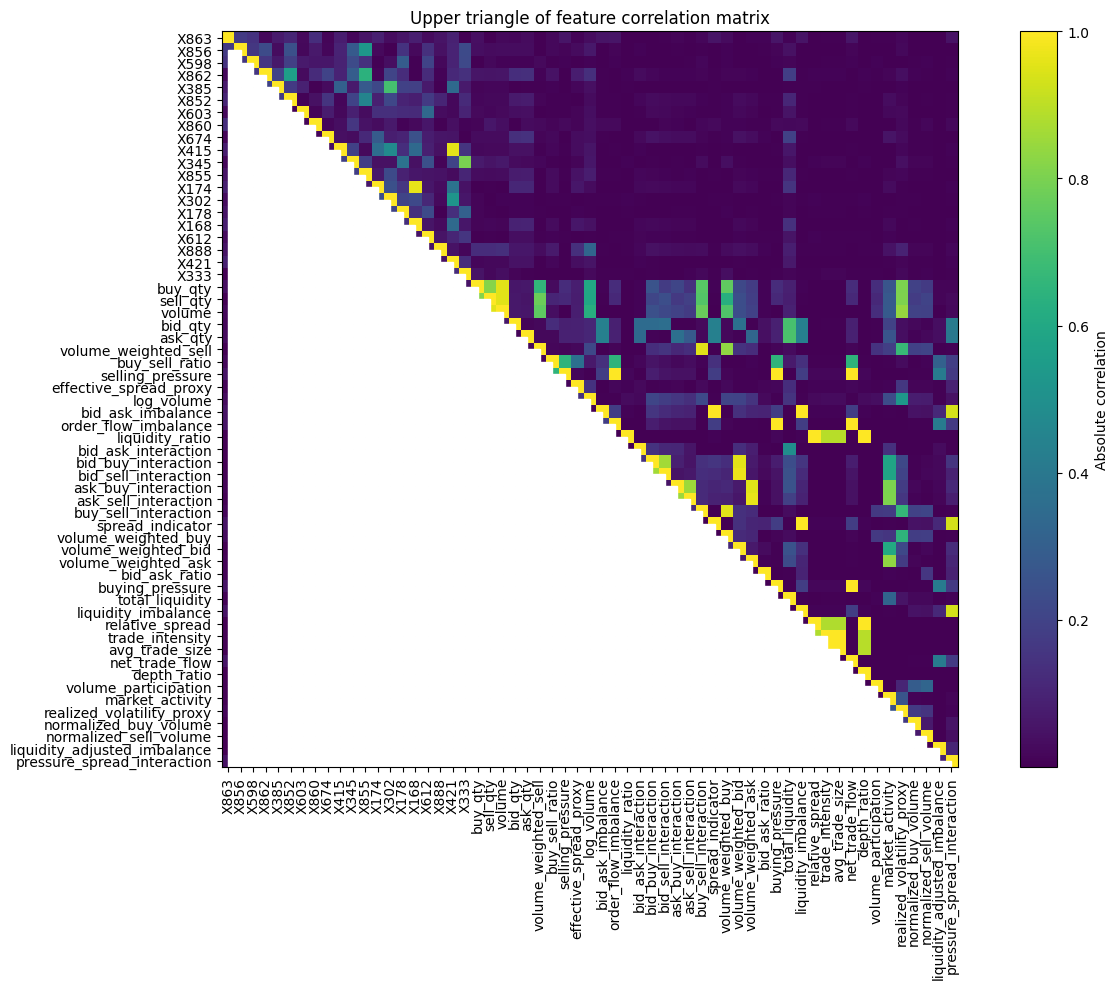

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation matrix for your features
corr_matrix = train[FEATURES].corr().abs()

# Mask the lower triangle and the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 10))
plt.title('Upper triangle of feature correlation matrix')
# Plot
plt.imshow(corr_matrix, cmap='viridis', interpolation='none')
plt.colorbar(label='Absolute correlation')

# Mask the lower triangle
for i in range(corr_matrix.shape[0]):
    for j in range(i):
        plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, color='white'))

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.tight_layout()
plt.show()

Remove highly correlated engineered features (keep base features regardless)

In [12]:
# List of base/original features to always keep
BASE_FEATURES = [
    "X863", "X856", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X855", "X174", "X302", "X178", "X168", "X612",
    "X888", "X421", "X333", "buy_qty", "sell_qty", "volume", "bid_qty", "ask_qty"
]

# Your selected features from SHAP (includes both base and engineered)
ALL_FEATURES = shap_summary['feature'].tolist()

# Identify engineered features (those NOT in the base feature list)
engineered_features = [f for f in ALL_FEATURES if f not in BASE_FEATURES]

# Calculate correlation matrix for engineered features only
corr_matrix = train[engineered_features].corr().abs()

# Mask the upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find engineered features with correlation > 0.95
high_corr = [column for column in upper.columns if any(upper[column] > 0.95)]

# Remove highly correlated engineered features (but keep all base features!)
engineered_features_uncorr = [f for f in engineered_features if f not in high_corr]


In [13]:
high_corr

['volume_weighted_sell',
 'volume_weighted_buy',
 'ask_buy_interaction',
 'depth_ratio',
 'volume_weighted_bid',
 'ask_sell_interaction',
 'order_flow_imbalance',
 'liquidity_imbalance',
 'selling_pressure',
 'net_trade_flow',
 'spread_indicator',
 'relative_spread',
 'trade_intensity']

Select the top k engineered features based on SHAP (from the uncorrelated set, exclude base features)

In [14]:
# Filter SHAP summary to only uncorrelated engineered features
shap_engineered = shap_summary[
    shap_summary['feature'].isin(engineered_features_uncorr)
]

# Select top k by SHAP value
topk_engineered = shap_engineered['feature'].iloc[:13].tolist()


In [16]:
# Combine all base features with top engineered features for final dataset
selected_features_final = BASE_FEATURES + topk_engineered

# Make sure the order is as you want (usually base features first)
print("Selected features (base + top 20 engineered):", selected_features_final)

train_data_reduced = train[selected_features_final + ['label']]
test_data_reduced = test[selected_features_final + ['label']]

print(train_data_reduced.shape, test_data_reduced.shape)


Selected features (base + top 20 engineered): ['X863', 'X856', 'X598', 'X862', 'X385', 'X852', 'X603', 'X860', 'X674', 'X415', 'X345', 'X855', 'X174', 'X302', 'X178', 'X168', 'X612', 'X888', 'X421', 'X333', 'buy_qty', 'sell_qty', 'volume', 'bid_qty', 'ask_qty', 'liquidity_ratio', 'buy_sell_interaction', 'log_volume', 'bid_buy_interaction', 'volume_weighted_ask', 'market_activity', 'volume_participation', 'total_liquidity', 'bid_sell_interaction', 'normalized_sell_volume', 'realized_volatility_proxy', 'effective_spread_proxy', 'bid_ask_imbalance']
(525887, 39) (538150, 39)


Use the selected features to retrain the model.

## Model Training (Ensemble: LightGBM + XGBoost)

In [ ]:
import xgboost as xgb
import lightgbm as lgb

# # Calculate the number of rows to use (latest 65%)
# n_total = len(train_data_reduced)
# n_65 = int(n_total * 0.65)

# # Slice to keep only the most recent 65%
# train_slice = train_data_reduced.iloc[-n_65:]

# X_train = train_slice.drop(columns=['label'])
# y_train = train_slice['label']

# Shuffle the train data (Intentionally not using time order here)
train_data_reduced_shuffled = train_data_reduced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
X_train = train_data_reduced_shuffled.drop(columns=['label'])
y_train = train_data_reduced_shuffled['label']

X_test = test_data_reduced.drop(columns=['label'])
y_test = test_data_reduced['label'] # Not used

# Train LightGBM
print("Training LightGBM...")
lgb_model = lgb.LGBMRegressor(verbose=-1)
lgb_model.fit(X_train, y_train)

# Train XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(tree_method="hist", device='cpu', n_jobs=4, verbosity=0)
xgb_model.fit(X_train, y_train)

# Predict and ensemble
print("Predicting and combining (ensemble)...")
lgb_pred = lgb_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
ensemble_pred = lgb_pred*0.3 + xgb_pred*0.7


Training LightGBM...
Training XGBoost...
Predicting and combining (ensemble)...


In [14]:
# Make predictions on test set (excluding 'ID' column for predictions)
X_test = test_data_reduced.drop(columns=['ID'], errors='ignore')  # Remove ID if present

In [ ]:
# Prepare submission
sub = pd.read_csv("/kaggle/input/drw-crypto-market-prediction/sample_submission.csv")
sub['prediction'] = ensemble_pred
sub.to_csv("submission.csv", index=False)

In [16]:
!kaggle competitions submit -c drw-crypto-market-prediction -f submission.csv -m "Weighted Ensemble: LGBM + XGBoost with Shuffle" --quiet

Successfully submitted to DRW - Crypto Market Prediction


## Model Training (Weighted Ensemble: LightGBM + XGBoost + Weighted KFold)

In [31]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

FOLDS = 5
kf = KFold(n_splits=FOLDS)
blend_weights = np.arange(0, 1.01, 0.1)
fold_weights = np.array([0.23646109, 0.14898818, 0.16302815, 0.23268628, 0.21883629])

xgb_params = {
    "tree_method": "gpu_hist",
    "colsample_bylevel": 0.4778,
    "colsample_bynode": 0.3628,
    "colsample_bytree": 0.7107,
    "gamma": 1.7095,
    "learning_rate": 0.02213,
    "max_depth": 20,
    "max_leaves": 12,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.3524,
    "reg_lambda": 75.4484,
    "subsample": 0.06567,
    "verbosity": 0
}

LGBM_PARAMS = {
    "boosting_type": "gbdt",
    "device": "gpu",
    "n_jobs": -1,
    "verbose": -1,
    "random_state": 42,
    "colsample_bytree": 0.5039,
    "learning_rate": 0.01260,
    "min_child_samples": 20,
    "min_child_weight": 0.1146,
    "n_estimators": 915,
    "num_leaves": 145,
    "reg_alpha": 19.2447,
    "reg_lambda": 55.5046,
    "subsample": 0.9709,
    "max_depth": 9
}

X = train_data_reduced.drop(columns=['label'])
y = train_data_reduced['label']
X_test = test_data_reduced.drop(columns=['label'])

# For every blend ratio, store OOF preds and test preds
oof_preds_blend = {alpha: np.zeros(len(X)) for alpha in blend_weights}
test_preds_blend = {alpha: np.zeros(len(X_test)) for alpha in blend_weights}
fold_test_preds_blend = {alpha: [] for alpha in blend_weights}

for fold_num, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"Fold: {fold_num + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # Train XGBoost
    model_xgb = xgb.XGBRegressor(**xgb_params)
    model_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    val_pred_xgb = model_xgb.predict(X_valid)
    test_pred_xgb = model_xgb.predict(X_test)

    # Train LightGBM
    model_lgb = lgb.LGBMRegressor(**LGBM_PARAMS)
    model_lgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    val_pred_lgb = model_lgb.predict(X_valid)
    test_pred_lgb = model_lgb.predict(X_test)

    for alpha in blend_weights:
        val_pred_blend = alpha * val_pred_xgb + (1 - alpha) * val_pred_lgb
        oof_preds_blend[alpha][valid_idx] = val_pred_blend
        test_pred_blend = alpha * test_pred_xgb + (1 - alpha) * test_pred_lgb
        fold_test_preds_blend[alpha].append(test_pred_blend)

# Combine test predictions using your custom fold weights for each blend
for alpha in blend_weights:
    test_preds = np.zeros(len(X_test))
    for w, preds in zip(fold_weights, fold_test_preds_blend[alpha]):
        test_preds += w * preds
    test_preds_blend[alpha] = test_preds

# Report OOF RMSE, Pearson and show the best blend
print("\nBlend weight results (alpha = XGB weight):")
best_pearson = -1
best_alpha = None
for alpha in blend_weights:
    rmse = np.sqrt(mean_squared_error(y, oof_preds_blend[alpha]))
    pearson = pearsonr(y, oof_preds_blend[alpha])[0]
    print(f"Alpha {alpha:.2f}: RMSE={rmse:.5f}, Pearson={pearson:.5f}")
    if pearson > best_pearson:
        best_pearson = pearson
        best_alpha = alpha

print(f"\nBest Pearson achieved at alpha={best_alpha:.2f} (XGB weight, LGBM weight={1-best_alpha:.2f}): {best_pearson:.5f}")
print("Corresponding weighted test predictions shape:", test_preds_blend[best_alpha].shape)


Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5

Blend weight results (alpha = XGB weight):
Alpha 0.00: RMSE=1.04703, Pearson=0.09998
Alpha 0.10: RMSE=1.04072, Pearson=0.10362
Alpha 0.20: RMSE=1.03501, Pearson=0.10736
Alpha 0.30: RMSE=1.02992, Pearson=0.11114
Alpha 0.40: RMSE=1.02544, Pearson=0.11487
Alpha 0.50: RMSE=1.02159, Pearson=0.11843
Alpha 0.60: RMSE=1.01838, Pearson=0.12167
Alpha 0.70: RMSE=1.01580, Pearson=0.12441
Alpha 0.80: RMSE=1.01388, Pearson=0.12644
Alpha 0.90: RMSE=1.01260, Pearson=0.12757
Alpha 1.00: RMSE=1.01197, Pearson=0.12765

Best Pearson achieved at alpha=1.00 (XGB weight, LGBM weight=0.00): 0.12765
Corresponding weighted test predictions shape: (538150,)


It seems that XGB is better alone.

In [34]:
# Make predictions on test set (excluding 'ID' column for predictions)
X_test = test_data_reduced.drop(columns=['ID'], errors='ignore')  # Remove ID if present

In [ ]:
# Prepare submission
sub = pd.read_csv("/kaggle/input/drw-crypto-market-prediction/sample_submission.csv")
sub['prediction'] = test_preds_blend[best_alpha]
sub.to_csv("submission.csv", index=False)

In [36]:
!kaggle competitions submit -c drw-crypto-market-prediction -f submission.csv -m "Weighted Ensemble: LightGBM + XGBoost + Weighted KFold" --quiet

Successfully submitted to DRW - Crypto Market Prediction


## Model Training (AutoGluon)

In [7]:
# Columns to exclude from training features
exclude_cols = ['timestamp', 'weekday', 'month']

# --- For train set ---
# Keep all columns except those to exclude
train_data_reduced = train_data_reduced.drop(columns=[col for col in exclude_cols if col in train.columns], errors='ignore')

In [8]:
# Train AutoGluon TabularPredictor
predictor = TabularPredictor(
    label='label',
    eval_metric='pearsonr'  # Use Pearson correlation as per competition
).fit(
    train_data=train_data_reduced,       # DataFrame with all features + label
    presets='best_quality', # Or use 'medium_quality' for faster runs
    time_limit=5555         # Optional: max training time in seconds
)


No path specified. Models will be saved in: "AutogluonModels\ag-20250622_143245"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:       14.01 GB / 31.86 GB (44.0%)
Disk Space Avail:   60.58 GB / 951.65 GB (6.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout

(_ray_fit pid=23336) [1000]	valid_set's l2: 0.378881	valid_set's pearsonr: 0.830665
(_ray_fit pid=15184) [2000]	valid_set's l2: 0.246102	valid_set's pearsonr: 0.888459 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=19740) [2000]	valid_set's l2: 0.25161	valid_set's pearsonr: 0.88932 [repeated 7x across cluster]
(_ray_fit pid=15184) [3000]	valid_set's l2: 0.185095	valid_set's pearsonr: 0.91527
(_ray_fit pid=16816) [3000]	valid_set's l2: 0.186941	valid_set's pearsonr: 0.91521
(_ray_fit pid=19740) [3000]	valid_set's l2: 0.190439	valid_set's pearsonr: 0.915244 [repeated 6x across cluster]
(_ray_fit pid=15184) [4000]	valid_set's l2: 0.149579	valid_set's pearsonr: 0.930868
(_ray_fit pid=31748) [4000]	valid_set's l2: 0.14787	valid_set's pearsonr: 0.931403
(_ray_fit pid=19740) [4000]	valid

(_dystack pid=21876) 	0.9647	 = Validation score   (pearsonr)
(_dystack pid=21876) 	449.47s	 = Training   runtime
(_dystack pid=21876) 	884.18s	 = Validation runtime
(_dystack pid=21876) Fitting model: LightGBM_BAG_L1 ... Training model for up to 81.47s of the 541.02s of remaining time.
(_dystack pid=21876) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=2, gpus=0, memory=2.40%)


(_ray_fit pid=21220) [1000]	valid_set's l2: 0.267731	valid_set's pearsonr: 0.886057
(_ray_fit pid=35460) [1000]	valid_set's l2: 0.24878	valid_set's pearsonr: 0.889597


(_ray_fit pid=6636) 	Ran out of time, early stopping on iteration 1389. Best iteration is:
(_ray_fit pid=6636) 	[1389]	valid_set's l2: 0.200796	valid_set's pearsonr: 0.913521
(_dystack pid=21876) 	0.9124	 = Validation score   (pearsonr)
(_dystack pid=21876) 	65.32s	 = Training   runtime
(_dystack pid=21876) 	36.39s	 = Validation runtime
(_dystack pid=21876) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 6.68s of the 466.23s of remaining time.
(_ray_fit pid=35460) 	Ran out of time, early stopping on iteration 1405. Best iteration is: [repeated 7x across cluster]
(_ray_fit pid=35460) 	[1405]	valid_set's l2: 0.194967	valid_set's pearsonr: 0.913402 [repeated 7x across cluster]
(_dystack pid=21876) 	Warning: Model is expected to require 2494.0s to train, which exceeds the maximum time limit of 5.7s, skipping model...
(_dystack pid=21876) 	Time limit exceeded... Skipping RandomForestMSE_BAG_L1.
(_dystack pid=21876) Fitting model: WeightedEnsemble_L2 ... Training model for

(_ray_fit pid=20404) [1000]	valid_set's l2: 0.0640119	valid_set's pearsonr: 0.968557 [repeated 7x across cluster]
(_ray_fit pid=9880) [2000]	valid_set's l2: 0.064165	valid_set's pearsonr: 0.96809 [repeated 8x across cluster]
(_ray_fit pid=9880) [3000]	valid_set's l2: 0.0612554	valid_set's pearsonr: 0.96956 [repeated 8x across cluster]
(_ray_fit pid=9880) [4000]	valid_set's l2: 0.0589834	valid_set's pearsonr: 0.970707 [repeated 8x across cluster]
(_ray_fit pid=33008) [4000]	valid_set's l2: 0.0543567	valid_set's pearsonr: 0.972769 [repeated 7x across cluster]
(_ray_fit pid=9880) [5000]	valid_set's l2: 0.0571453	valid_set's pearsonr: 0.971634
(_ray_fit pid=19144) [5000]	valid_set's l2: 0.0519897	valid_set's pearsonr: 0.975107
(_ray_fit pid=33008) [5000]	valid_set's l2: 0.0525464	valid_set's pearsonr: 0.973689 [repeated 6x across cluster]
(_ray_fit pid=19144) [6000]	valid_set's l2: 0.0503707	valid_set's pearsonr: 0.975895
(_ray_fit pid=9880) [6000]	valid_set's l2: 0.0555456	valid_set's pea

(_ray_fit pid=33008) 	Ran out of time, early stopping on iteration 7885. Best iteration is:
(_ray_fit pid=33008) 	[7885]	valid_set's l2: 0.0484586	valid_set's pearsonr: 0.975766
(_dystack pid=21876) 	0.9754	 = Validation score   (pearsonr)
(_dystack pid=21876) 	345.94s	 = Training   runtime
(_dystack pid=21876) 	687.7s	 = Validation runtime
(_ray_fit pid=19144) 	Ran out of time, early stopping on iteration 8064. Best iteration is: [repeated 7x across cluster]
(_ray_fit pid=19144) 	[8064]	valid_set's l2: 0.0476977	valid_set's pearsonr: 0.977192 [repeated 7x across cluster]
(_dystack pid=21876) Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.00s of the -7.76s of remaining time.
(_dystack pid=21876) 	Ensemble Weights: {'LightGBMXT_BAG_L2': 1.0}
(_dystack pid=21876) 	0.9754	 = Validation score   (pearsonr)
(_dystack pid=21876) 	1.26s	 = Training   runtime
(_dystack pid=21876) 	0.01s	 = Validation runtime
(_dystack pid=21876) AutoGluon training complete, total runtime = 

In [11]:
# Check leaderboard (model performance on training data with validation split)
leaderboard = predictor.leaderboard(silent=True)
print(leaderboard)

                     model  score_val eval_metric  pred_time_val     fit_time  \
0      WeightedEnsemble_L3   0.988525    pearsonr    4203.968562  2916.754384   
1          LightGBM_BAG_L2   0.988519    pearsonr    3282.713556  2440.177084   
2        LightGBMXT_BAG_L2   0.987189    pearsonr    3302.875423  2452.020170   
3          CatBoost_BAG_L2   0.984627    pearsonr    2381.838785  2103.600484   
4      WeightedEnsemble_L2   0.983002    pearsonr     942.465253   880.419152   
5          LightGBM_BAG_L1   0.981015    pearsonr     932.156931   376.274344   
6   RandomForestMSE_BAG_L1   0.976538    pearsonr      10.294141   501.357794   
7     ExtraTreesMSE_BAG_L1   0.973758    pearsonr      12.891963    63.680735   
8        LightGBMXT_BAG_L1   0.966170    pearsonr     983.416468   368.899231   
9          CatBoost_BAG_L1   0.915976    pearsonr       1.049273   607.378577   
10  NeuralNetFastAI_BAG_L1   0.779384    pearsonr       4.421388    48.007139   
11          XGBoost_BAG_L1  

In [10]:
# Make predictions on test set (excluding 'ID' column for predictions)
X_test = test_data_reduced.drop(columns=['ID'], errors='ignore')  # Remove ID if present
test_preds = predictor.predict(X_test)

In [ ]:
# Prepare submission
sub = pd.read_csv("/kaggle/input/drw-crypto-market-prediction/sample_submission.csv")
sub['prediction'] = test_preds
sub.to_csv("submission.csv", index=False)

In [14]:
!kaggle competitions submit -c drw-crypto-market-prediction -f submission.csv -m "AutoGluon with feature engineering" --quiet

Successfully submitted to DRW - Crypto Market Prediction


# Citation

- DRW Trading Group. DRW - Crypto Market Prediction. https://kaggle.com/competitions/drw-crypto-market-prediction, 2025. Kaggle.
- https://www.kaggle.com/code/sadettinamilverdil/yat-r-m-tavsiyesi-de-ildir
- https://www.kaggle.com/code/taylorsamarel/low-signal-to-noise/notebook
